# Load data and imports

In this section, we just clone the repository and load the dataset in a DataFrame splitting the dataset by "Canti"

In [ ]:
!git clone https://github.com/FrancescoFarinola/divine-comedy-text-generation

fatal: il percorso di destinazione 'divine-comedy-text-generation' esiste già e non è una directory vuota.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
import time
import re
import random

%matplotlib inline

sys.path.append('/content/divine-comedy-text-generation')

path = 'divine-comedy-text-generation/'
filenames = ['inferno.txt', 'purgatorio.txt', 'paradiso.txt']

columns =  ['Cantica', 'Canto', 'Text']
data = []
for file in filenames:
  filepath = path + file
  with open(filepath, 'r') as f:
    lines = f.readlines()
    start = True
    for line in lines:
      if 'Canto' in line:
        if start: 
          row = np.empty(3, dtype=object)
          start = False
        else:
          row[2] = canto
          data.append(row)
          row = np.empty(3, dtype=object)
        head = line.split()
        row[0] = head[0]
        row[1] = head[3]
        canto = ""
      elif line != "\n":
        canto = canto + line
    row[2] = canto  
    data.append(row)
    f.close()

df = pd.DataFrame(data, columns=columns)

df

,Cantica,Canto,Text
0,Inferno,I,Nel mezzo del cammin di nostra vita\n mi ri...
1,Inferno,II,"Lo giorno se n’andava, e l’aere bruno\n tog..."
2,Inferno,III,"“Per me si va ne la città dolente,\n per me..."
3,Inferno,IV,Ruppemi l’alto sonno ne la testa\n un greve...
4,Inferno,V,Così discesi del cerchio primaio\n giù nel ...
...,...,...,...
95,Paradiso,XXIX,"Quando ambedue li figli di Latona,\n copert..."
96,Paradiso,XXX,Forse semilia miglia di lontano\n ci ferve ...
97,Paradiso,XXXI,In forma dunque di candida rosa\n mi si mos...
98,Paradiso,XXXII,"Affetto al suo piacer, quel contemplante\n ..."


In [2]:
df.Text[0]

'  Nel mezzo del cammin di nostra vita\n  mi ritrovai per una selva oscura,\n  ché la diritta via era smarrita.\n  Ahi quanto a dir qual era è cosa dura\n  esta selva selvaggia e aspra e forte\n  che nel pensier rinova la paura!\n  Tant’ è amara che poco è più morte;\n  ma per trattar del ben ch’i’ vi trovai,\n  dirò de l’altre cose ch’i’ v’ho scorte.\n  Io non so ben ridir com’ i’ v’intrai,\n  tant’ era pien di sonno a quel punto\n  che la verace via abbandonai.\n  Ma poi ch’i’ fui al piè d’un colle giunto,\n  là dove terminava quella valle\n  che m’avea di paura il cor compunto,\n  guardai in alto e vidi le sue spalle\n  vestite già de’ raggi del pianeta\n  che mena dritto altrui per ogne calle.\n  Allor fu la paura un poco queta,\n  che nel lago del cor m’era durata\n  la notte ch’i’ passai con tanta pieta.\n  E come quei che con lena affannata,\n  uscito fuor del pelago a la riva,\n  si volge a l’acqua perigliosa e guata,\n  così l’animo mio, ch’ancor fuggiva,\n  si volse a retro a

# Preprocessing

In [3]:
import re
from functools import reduce
import string


PUNCTUATION_RE = re.compile("[-—!?:;,.«»“”]")


def clean_start(text):
    return text.replace("  ", "", 1)

def remove_double_whitespaces(text):
    return text.replace("  ", "")

def remove_punctuation(text):
    return PUNCTUATION_RE.sub("", text)

def clean_newline(text):
    return text.replace("\n", " \n ")

def space_apostrophe(text):
    return text.replace("’", "'")

def replace_uncommon_symbols(text):
    """
    Replace uncomoon symbols with particular accents
    """
    text = text.replace("ä", "a")
    text = text.replace("é", "è")
    text = text.replace("ë", "è")
    text = text.replace("Ë", "E")
    text = text.replace("ï", "i")
    text = text.replace("Ï", "I")
    text = text.replace("ó", "ò")
    text = text.replace("ö", "o")
    text = text.replace("ü", "u")
    text = text.replace("(", "-")
    text = text.replace(")", "-")
    text = text.replace("[", "")
    text = text.replace("]", "")
    text = text.replace("ï", "i")
    return text


def lower(text):
    return text.lower()

def adjust_newline(text):
    return text.replace("\n ", "\n")


def preprocessing(text):
    return reduce(lambda text, f: f(text), PREPROCESSING_PIPELINE, text)


PREPROCESSING_PIPELINE = [remove_double_whitespaces,
                          remove_punctuation,
                          remove_double_whitespaces,
                          space_apostrophe,
                          replace_uncommon_symbols,
                          clean_newline]

In [4]:
df['Text'] = df['Text'].apply(lambda x: preprocessing(x))
df['Text'][0]

"Nel mezzo del cammin di nostra vita \n mi ritrovai per una selva oscura \n chè la diritta via era smarrita \n Ahi quanto a dir qual era è cosa dura \n esta selva selvaggia e aspra e forte \n che nel pensier rinova la paura \n Tant' è amara che poco è più morte \n ma per trattar del ben ch'i' vi trovai \n dirò de l'altre cose ch'i' v'ho scorte \n Io non so ben ridir com' i' v'intrai \n tant' era pien di sonno a quel punto \n che la verace via abbandonai \n Ma poi ch'i' fui al piè d'un colle giunto \n là dove terminava quella valle \n che m'avea di paura il cor compunto \n guardai in alto e vidi le sue spalle \n vestite già de' raggi del pianeta \n che mena dritto altrui per ogne calle \n Allor fu la paura un poco queta \n che nel lago del cor m'era durata \n la notte ch'i' passai con tanta pieta \n E come quei che con lena affannata \n uscito fuor del pelago a la riva \n si volge a l'acqua perigliosa e guata \n così l'animo mio ch'ancor fuggiva \n si volse a retro a rimirar lo passo \n

# Markov Chain text generation

In [ ]:
!pip install markovify

  Preparing metadata (setup.py) ... - done
  Created wheel for markovify: filename=markovify-0.9.3-py3-none-any.whl size=18622 sha256=23ae42b260fd4baa27c0fa67f7857529c16bc88ce0c445a8a5359fe3d7cfdd7f
  Stored in directory: /home/francesco/.cache/pip/wheels/6c/95/65/1d19e9b347e1027eeb1a6988af4a429ab7215f00d26dc6634b
Successfully built markovify


In [ ]:
import markovify
corpus = [text for text in df.Text]
corpus = reduce(lambda x,y: x+y, corpus)
model = markovify.NewlineText(corpus)

In [ ]:
for i in range(2):
    print()
    for i in range(0, 3):
        print(model.make_short_sentence(40))


e li atti loro a veder care,
de l’Eneïda dico, la qual mi fece dono.
distruggitor di sé claustro

con Amiclate, al suon del trino spiro,
che mi dà di pianger più che burro.
che quel de l’Arca,


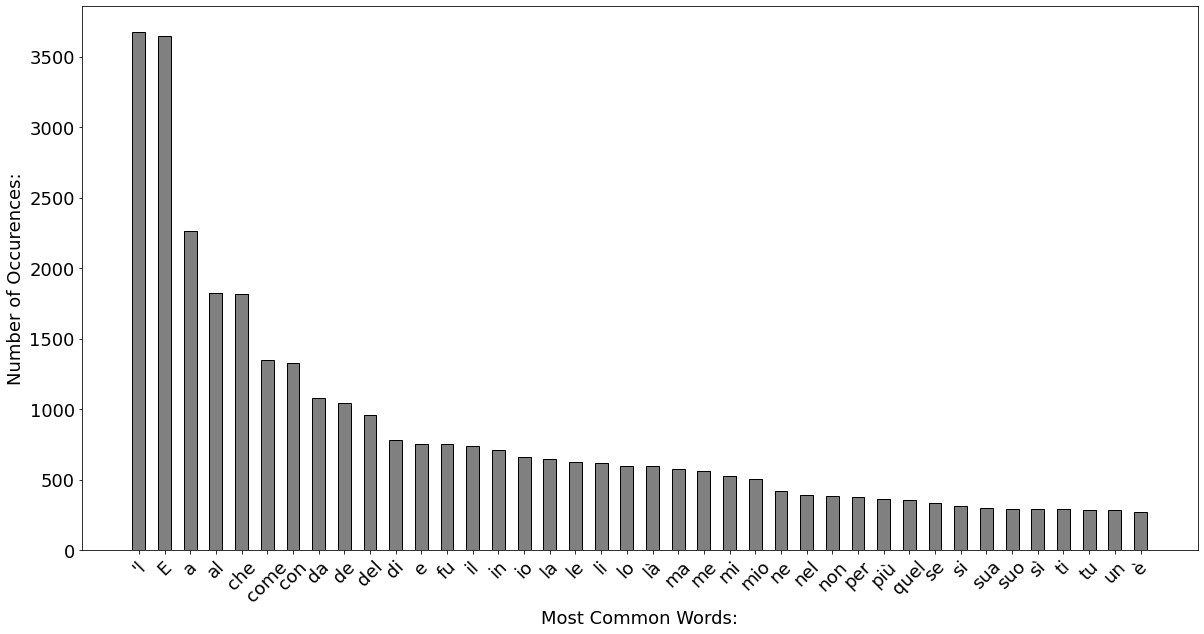

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
def plotWordFrequency(df):
    words = [line.split() for text in df.Text for line in text.split("\n") ]
    words = reduce(lambda x,y: x+y, words)
    data = sorted([(w, words.count(w)) for w in set(words)], key = lambda x:x[1], reverse=True)[:40] 
    most_words = [x[0] for x in data]
    times_used = [int(x[1]) for x in data]
    plt.figure(figsize=(20,10))
    plt.bar(x=sorted(most_words), height=times_used, color = 'grey', edgecolor = 'black',  width=.5)
    plt.xticks(rotation=45, fontsize=18)
    plt.yticks(rotation=0, fontsize=18)
    plt.xlabel('Most Common Words:', fontsize=18)
    plt.ylabel('Number of Occurences:', fontsize=18)
    plt.show()

plotWordFrequency(df)

# Character-level text generation

We lower the text as character-level text generation works better w/o capital letters. Without lowering, the model would have double the classes as output and this may result in more memory usage and maybe also misleading predictions.

We make a copy of the dataset before preprocessing, since we are going to use the same dataset later for text generation using seq2seq.

##Preprocessing

In [ ]:
PREPROCESSING_PIPELINE = [lower]
df1 = df.copy()
df1['Text'] = df1['Text'].apply(lambda x: preprocessing(x))
df1['Text'][0]

'  nel mezzo del cammin di nostra vita\n  mi ritrovai per una selva oscura,\n  ché la diritta via era smarrita.\n  ahi quanto a dir qual era è cosa dura\n  esta selva selvaggia e aspra e forte\n  che nel pensier rinova la paura!\n  tant’ è amara che poco è più morte;\n  ma per trattar del ben ch’i’ vi trovai,\n  dirò de l’altre cose ch’i’ v’ho scorte.\n  io non so ben ridir com’ i’ v’intrai,\n  tant’ era pien di sonno a quel punto\n  che la verace via abbandonai.\n  ma poi ch’i’ fui al piè d’un colle giunto,\n  là dove terminava quella valle\n  che m’avea di paura il cor compunto,\n  guardai in alto e vidi le sue spalle\n  vestite già de’ raggi del pianeta\n  che mena dritto altrui per ogne calle.\n  allor fu la paura un poco queta,\n  che nel lago del cor m’era durata\n  la notte ch’i’ passai con tanta pieta.\n  e come quei che con lena affannata,\n  uscito fuor del pelago a la riva,\n  si volge a l’acqua perigliosa e guata,\n  così l’animo mio, ch’ancor fuggiva,\n  si volse a retro a

First, we flatten the text corpus

In [ ]:
corpus = [text for text in df1.Text]
corpus = reduce(lambda x,y: x+y, corpus)

Then, we create the character listing along with the relative dictioneries that map each character to an integer and viceversa.

In [ ]:
def create_idx(df):
  unique_chars = set()
  for text in df.Text:
    unique_chars = list(set(unique_chars) | set(text))
  unique_chars.sort()
  char2idx = {char[1]: char[0] for char in enumerate(unique_chars)}
  idx2char = {v: k for k, v in char2idx.items()}
  return unique_chars, char2idx, idx2char

char_listing, char2idx, idx2char = create_idx(df1)

In [ ]:
print(char2idx)

{'\n': 0, ' ': 1, '!': 2, '"': 3, '(': 4, ')': 5, ',': 6, '-': 7, '.': 8, ':': 9, ';': 10, '?': 11, 'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19, 'i': 20, 'j': 21, 'l': 22, 'm': 23, 'n': 24, 'o': 25, 'p': 26, 'q': 27, 'r': 28, 's': 29, 't': 30, 'u': 31, 'v': 32, 'x': 33, 'y': 34, 'z': 35, '«': 36, '»': 37, 'à': 38, 'ä': 39, 'è': 40, 'é': 41, 'ë': 42, 'ì': 43, 'ï': 44, 'ò': 45, 'ó': 46, 'ö': 47, 'ù': 48, 'ü': 49, '—': 50, '‘': 51, '’': 52, '“': 53, '”': 54}


We transform the corpus text into an encoded corpus where each integer correspond to a character using the previously defined dictionary.

In [ ]:
def numerical_encoding(df, char2idx):
    """ Text to list of chars, to np.array of numerical idx """
    chars_list = [char for text in df.Text for char in text]
    chars_list = [char2idx[char] for char in chars_list]
    chars_list = np.array(chars_list)
    return chars_list

def decode_sequence(seq):
  decoded = [idx2char[i] for i in seq]
  return ''.join(decoded)

encoded_corpus = numerical_encoding(df1, char2idx)

##Input preparation

In the following cell:


*   `from_tensor_slices`: creates a Dataset whose elements are slices of the given tensors. The given tensors are sliced along their first dimension. This operation preserves the structure of the input tensors, removing the first dimension of each tensor and using it as the dataset dimension. 

  Then apply `batch` since we have a sequence of integers representing characters which is much longer so it is much helpful if we divide this into many sequences of `SEQUENCE_LENGTH+1`.
  
  We use `drop_remainder=True` whether the last batch should be dropped in the case it has fewer than batch_size elements;

*   Creating batches pipeline:
  
  1. `map` for each sequence created before with `from_tensor_slices` applies the function `split_input_target` which returns the input and output sequences for the model. i.e. We have a sequence `Nel mezzo del`: respectively the input text will be `Nel mezzo de` and the output will be `el mezzo del`
  2. `shuffle` namely shuffles the sequences
  3. `batch` namely creates batches of length `BATCH_SIZE` with sequences shuffled.







In [ ]:
SEQ_LENGTH = 100
BATCH_SIZE = 128
BUFFER_SIZE = 10000
example_per_epoch = len(corpus)//SEQ_LENGTH

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

sequences = tf.data.Dataset.from_tensor_slices(encoded_corpus).batch(batch_size=SEQ_LENGTH+1, drop_remainder=True)

dataset = sequences.map(split_input_target)

for input_ex, target_ex in dataset.take(2):
  print('Input data: ', repr(decode_sequence(input_ex.numpy())))
  print('Output data: ', repr(decode_sequence(target_ex.numpy())))
  print("\n")

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

Input data:  '  nel mezzo del cammin di nostra vita\n  mi ritrovai per una selva oscura,\n  ché la diritta via era s'
Output data:  ' nel mezzo del cammin di nostra vita\n  mi ritrovai per una selva oscura,\n  ché la diritta via era sm'


Input data:  'arrita.\n  ahi quanto a dir qual era è cosa dura\n  esta selva selvaggia e aspra e forte\n  che nel pen'
Output data:  'rrita.\n  ahi quanto a dir qual era è cosa dura\n  esta selva selvaggia e aspra e forte\n  che nel pens'




##Building the model

In [ ]:
VOCAB_SIZE = len(char_listing)# The embedding dimension
EMBEDDING_DIM = 256 
UNITS = 512

def build_model(vocab_size, embedding_dim, units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim = embedding_dim, batch_input_shape = [batch_size, None]),
        tf.keras.layers.GRU(units * 2, return_sequences= True, stateful=True, recurrent_initializer='glorot_uniform'),
        tf.keras.layers.GRU(units, return_sequences= True, stateful=True, recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

model = build_model(vocab_size = VOCAB_SIZE,
                    embedding_dim = EMBEDDING_DIM,
                    units = UNITS,
                    batch_size = BATCH_SIZE)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (128, None, 256)          14080     
                                                                 
 gru (GRU)                   (128, None, 1024)         3938304   
                                                                 
 gru_1 (GRU)                 (128, None, 512)          2362368   
                                                                 
 dense_2 (Dense)             (128, None, 55)           28215     
                                                                 
Total params: 6,342,967
Trainable params: 6,342,967
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='Adam', loss=loss)
# Directory where the checkpoints will be saved

checkpoint_dir = './training_checkpoints'# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only=True)

early_stop=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

EPOCHS = 50
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback, early_stop])

Epoch 1/50
42/42 [==============================] - 11s 206ms/step - loss: 0.2840
Epoch 2/50
42/42 [==============================] - 9s 203ms/step - loss: 0.2654
Epoch 3/50
42/42 [==============================] - 9s 203ms/step - loss: 0.2615
Epoch 4/50
42/42 [==============================] - 9s 204ms/step - loss: 0.2595
Epoch 5/50
42/42 [==============================] - 9s 205ms/step - loss: 0.2592
Epoch 6/50
42/42 [==============================] - 9s 204ms/step - loss: 0.2581
Epoch 7/50
42/42 [==============================] - 9s 204ms/step - loss: 0.2548
Epoch 8/50
42/42 [==============================] - 9s 203ms/step - loss: 0.2531
Epoch 9/50
42/42 [==============================] - 9s 202ms/step - loss: 0.2535
Epoch 10/50
42/42 [==============================] - 9s 204ms/step - loss: 0.2494
Epoch 11/50
42/42 [==============================] - 9s 202ms/step - loss: 0.2489
Epoch 12/50
42/42 [==============================] - 9s 203ms/step - loss: 0.2474
Epoch 13/50
42/42 [=====

##Temperature Char-level Sampling 

We first create a new inference model with `batch_size = 1`, load the latest checkpoint weights and define the input shape.

The function `char_level_temperature_sampling` takes in input 
* the model (`model`), 
* the start string to define the context (`start_string`), 
* the number of characters to generate (`chars_to_generate`) and 
* the `temperature` which defines how distant the predictions are far from the dataset (the smaller, the more similar to the input dataset)

After encoding the input_string which defines the context, we reset the states of the model to make independent call from the fit method, and then start to generate the next characters with iterative calls to the model.

Only in the first call we pass the entire input string since the model is stateful and we do not need to pass the whole sequence on recurrent calls. So as, when recurrently calling the model, we simply pass the last character ID.

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)
model = build_model(VOCAB_SIZE, EMBEDDING_DIM, UNITS, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir)) 
model.build(tf.TensorShape([1, None]))

In [ ]:
def char_level_temperature_sampling(model, start_string, chars_to_generate, temperature):
    input_eval = [char2idx[s] for s in start_string] #Convert input_string to correspondent encoding
    input_eval = tf.expand_dims(input_eval, axis=0) #reshape according to model input shape (1, None)
    text_generated = [] #string for storing results 
    model.reset_states() #reset states of the model to make calls to the model independent from previous calls (fit, predict, evaluate)
    for i in range(chars_to_generate):
        predictions = model(input_eval) #predict the next character
        predictions = tf.squeeze(predictions, 0) #squeeze results
        predictions = predictions / temperature #apply temperature
        
        #Draws num_samples from a categorical distribution of logits
        #This is applied to the last timestep (-1) to get the next char to generate
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy() 
        
        # Pass the predicted character as the next input to the 
        # model along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)   
        text_generated.append(idx2char[predicted_id])
        
    return ''.join(text_generated)

start_string = u"nel mezzo del cammin di nostra vita mi ritrovai"
char_level_generation = char_level_temperature_sampling(model, start_string=start_string, 
                                                        chars_to_generate=500, temperature=0.5)
print(start_string, char_level_generation)

nel mezzo del cammin di nostra vita mi ritrovai 
  per me si va ne l’etterno pianto,
  «guarda», mi disse, «le feroci stolta,
  se non pianger sonaregiando noi la soggio non posso,
  come mosser li astor celestïali;
  ma vidi bene e l’uno e l’altro mosso.
  sentendo fenne.
  la prima vita del ciglio e la quinta
  ti fa maravigliar, perché ne vedi
  la regïon de li angeli neri
  che vegnan d’esto fondo a dipartirco».
  la luce in che rideva il mio tesoro
  ch’io trovai lì, si fé prima corso,
  per ch’io a lui: «se tu riduci a mente
  qual fost


# Seq2Seq text generation

In this section we will experiment other text generation techniques using a Seq2Seq model. We will use:

* SpaCy for Italian word embeddings

* SymSpellPy italian vocabulary to handle out-of-vocabulary words




In [5]:
%%capture
!pip install spacy --upgrade
!python -m spacy download it_core_news_lg
import spacy
nlp = spacy.load("it_core_news_lg")

In [6]:
!pip install symspellpy
from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path=path+"it-100k.txt"
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

True

Adjust the newline token to get a better splitting on sequences

In [7]:
PREPROCESSING_PIPELINE = [adjust_newline]
df['Text'] = df['Text'].apply(lambda x: preprocessing(x))
df['Text'][0]

"Nel mezzo del cammin di nostra vita \nmi ritrovai per una selva oscura \nchè la diritta via era smarrita \nAhi quanto a dir qual era è cosa dura \nesta selva selvaggia e aspra e forte \nche nel pensier rinova la paura \nTant' è amara che poco è più morte \nma per trattar del ben ch'i' vi trovai \ndirò de l'altre cose ch'i' v'ho scorte \nIo non so ben ridir com' i' v'intrai \ntant' era pien di sonno a quel punto \nche la verace via abbandonai \nMa poi ch'i' fui al piè d'un colle giunto \nlà dove terminava quella valle \nche m'avea di paura il cor compunto \nguardai in alto e vidi le sue spalle \nvestite già de' raggi del pianeta \nche mena dritto altrui per ogne calle \nAllor fu la paura un poco queta \nche nel lago del cor m'era durata \nla notte ch'i' passai con tanta pieta \nE come quei che con lena affannata \nuscito fuor del pelago a la riva \nsi volge a l'acqua perigliosa e guata \ncosì l'animo mio ch'ancor fuggiva \nsi volse a retro a rimirar lo passo \nche non lasciò già mai pe

In [8]:
corpus = [text for text in df.Text]
corpus = reduce(lambda x,y: x+y, corpus)
tokens = nlp(corpus)
sequences = [nlp(line) for text in df.Text for line in text.split(" \n")]

##Word embeddings

The `spell_correction` function looks up for the most similar word using the symspellpy italian vocabulary with `max_edit_distance = 1`.

This function will be called only if the strategy of the `compute_embeddings` function will be `similarity`. By doing so, when assigning word embeddings of OOV words, this function will try to spell correctly a word in order to assign the word embedding of the word spelled correctly.

In [9]:
def spell_correction(text):
    results = [t if (t.isnumeric() or  len(t)<=3)
               else sym_spell.lookup(t, Verbosity.TOP, max_edit_distance=1, 
                                     include_unknown=True)[0].term 
               for t in text.split()]
    return ' '.join(results)

The `compute_embeddings` function assigns SpaCy word embeddings to in-vocabulary words and handle OOV terms in different ways:

* `strategy='similarity'` and `random_oov=False`: will spell correct the oov term and try to assign the embedding of the similar word

* `strategy='similarity'` and `random_oov=False`: will assign to the oov term a random vector

* `strategy='random'`: will assign to all the word embeddings a random vector, including in-vocabulary terms

In [10]:
EMBEDDING_DIM = 300

def compute_embeddings(tokens, nlp, EMBEDDING_DIM, strategy="similarity", random_oov=False):
    print(f"There are {len(list(set([word.text for word in tokens])))} unique tokens")
    embeddings = {} #Initialize embedding dict
    oov_words = {} #Initialize oov dict
    cc = 0 #counter for oov terms

    #Initializing special words embeddings
    embeddings["<PAD>"] = np.zeros((EMBEDDING_DIM,))
    embeddings["<SOS>"] = np.random.uniform(-1, 1, (EMBEDDING_DIM,))
    embeddings["<EOS>"] = np.random.uniform(-1, 1, (EMBEDDING_DIM,))
    embeddings["\n "] = np.random.uniform(-1, 1, (EMBEDDING_DIM,))
    
    for word in tokens: #for each word in the dataset
      if word.text not in embeddings: #if a unique word has not been processed yet
        if strategy == "similarity":
          if word.has_vector: #if the word has a corresponding word vector in SpaCy
            embeddings[word.text] = word.vector #Add the word vector to the vocabulary
          elif random_oov: #If random strategy for oov terms assign a random vector
            cc = cc+1
            embeddings[word.text] = np.random.uniform(-1, 1, (EMBEDDING_DIM,))
          else:
            cc = cc+1
            similar_word = spell_correction(word.text) #Find a similar word
            similar_token = nlp(similar_word) #Get the corresponding token in SpaCy
            oov_words[word.text] = similar_word #Fill the oov dict with [misspelled, correclty spelled] word
            #If the new word has a vector we assign the vector to the original word, otherwise a random vector
            if similar_token.has_vector and similar_word != word.text: 
                embeddings[word.text] = similar_token.vector
            else:
                embeddings[word.text] = np.random.uniform(-1, 1, (EMBEDDING_DIM,))
        #If random strategy assign to all words a random vector
        if strategy == "random":
          embeddings[word.text] = np.random.uniform(-1, 1, (EMBEDDING_DIM,))


    print(f"There are {cc} words for which we created an embedding")
    #Compute idx2word and word2idx dictionaries
    idx2word = dict([(idx,v) for idx,v in enumerate(list(embeddings.keys()))])
    word2idx = {v: k for k, v in idx2word.items()}

    #Initialize  the embedding matrix as a numpy array and fill it with all the vectors throught the embeddings dict
    embedding_matrix = np.zeros((len(idx2word), EMBEDDING_DIM))
    for word, i in word2idx.items():
        embedding_vector = embeddings[word]
        #Words not found in embedding index will be all-zeros.
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix, oov_words, idx2word, word2idx


embedding_matrix, oov_dict, idx2word, word2idx = compute_embeddings(tokens, nlp, EMBEDDING_DIM)

There are 13529 unique tokens
There are 4059 words for which we created an embedding


Here, we check how some OOV are handled, with which term and vector they are substituted.

In [11]:
print("Some out-of-vocabulary words with their respective word substituted:")
for k, v in list(oov_dict.items())[2:10]:
    oovtest = nlp(v)
    print(f"OOV word: {k}, \t vector used: {v} \t {oovtest.vector[:5]}")
print("\n")

zero_vectors = np.where(np.count_nonzero(embedding_matrix, axis=1)==0)[0]
print(f"There are {zero_vectors.shape[0]} words with zero vectors. Here we show some:")
print(np.array([idx2word[i] for i in zero_vectors])[:50])

Some out-of-vocabulary words with their respective word substituted:
OOV word: ridir, 	 vector used: ridir 	 [0. 0. 0. 0. 0.]
OOV word: intrai, 	 vector used: entrai 	 [ 0.83551  0.2146  -0.78065 -1.2835  -1.451  ]
OOV word: èi, 	 vector used: èi 	 [0. 0. 0. 0. 0.]
OOV word: macolato, 	 vector used: maculato 	 [-0.38396  0.85145 -0.33377 -1.6229  -1.5451 ]
OOV word: mpediva, 	 vector used: impediva 	 [ 0.76814  1.9516  -1.61    -0.35673 -0.10835]
OOV word: gaetta, 	 vector used: gaeta 	 [ 0.88015  -1.9323    1.1862    0.2662   -0.023887]
OOV word: tremesse, 	 vector used: premesse 	 [ 1.6344    0.78347  -0.039451  1.1204    1.7222  ]
OOV word: sembiava, 	 vector used: sembrava 	 [ 1.3384   1.3271  -0.76626 -1.1606  -0.10625]


There are 96 words with zero vectors. Here we show some:
['<PAD>' '\n' 'risonavan' 'gittansi' 'ubidente' 'salutevol' 'farmisi'
 'mugghia' 'disiato' 'caggiono' 'rabbuffa' 'avaccio' 'ruffian' 'adeschi'
 'menommi' 'tacerci' 'dienno' 'distorse' 'appressavan' 'temesti

##Preprocessing

We inspect the sequences length to define a proper maximum sequence length for the model.
We will set two maximum sequence lengths: one for the encoder and one for the decoder. The decoder will have 1 token more since its input will include the `<SOS>` token and the output the `<EOS>` token.


In [12]:
def check_max_sequence_length(sequences):
    from collections import Counter
    len_seq = [len(s) for s in sequences]
    len_frequencies = Counter(list(len_seq))
    print(f"List of tuples of (line length, # of lines):\n{sorted(len_frequencies.items())}")

    #Print unnecessary lines which are too short or too long that may cause misleading predictions
    #Also choosing a bigger MAX_SEQUENCE_LENGTH may cause more computational time.
    print(f"There are {len_frequencies[1]} lines with length 0 (will be excluded from dataset)")
    for i, value in enumerate(len_seq):
      if value==3 or value>=14:
        print(f"Length: {value}\t Line: {sequences[i]}")

check_max_sequence_length(sequences)

List of tuples of (line length, # of lines):
[(0, 100), (3, 12), (4, 182), (5, 1046), (6, 2802), (7, 3991), (8, 3351), (9, 1786), (10, 722), (11, 252), (12, 63), (13, 20), (14, 4), (15, 2)]
There are 0 lines with length 0 (will be excluded from dataset)
Length: 15	 Line: l'umana spezie e 'l loco e 'l tempo e 'l seme
Length: 14	 Line: e sta 'n su quel più che 'n su l'altro eretto
Length: 14	 Line: così com' ella sie' tra 'l piano e 'l monte
Length: 14	 Line: tra 'l quinto dì e 'l sesto ond' io mi diedi
Length: 3	 Line: maravigliando diventaro smorte
Length: 15	 Line: tra 'l Po e 'l monte e la marina e 'l Reno
Length: 3	 Line: lungamente mostrando paganesmo
Length: 3	 Line: apparecchiava grazioso loco
Length: 3	 Line: superillustrans claritate tua
Length: 3	 Line: silogizzò invidiosi veri
Length: 3	 Line: cotanto gloriosamente accolto
Length: 3	 Line: etternalmente rimanendosi una
Length: 3	 Line: DILIGITE IUSTITIAM primai
Length: 3	 Line: surgono innumerabili faville
Length: 3	 Line: co

We choose a `MAX_SEQ_LEN` of 11 as a tradeoff in order to discard few and unnecessary long sequences that would increase the model complexity and training time.

Then, we clean the dataset from too long and too short sequences.

In [13]:
MAX_SEQ_LEN_ENCODER = 11
MAX_SEQ_LEN_DECODER = MAX_SEQ_LEN_ENCODER + 1

In [14]:
def clean_dataset(sequences, MAX_SEQ_LEN_ENCODER):
    len_seq = [len(s) for s in sequences]
    indices = []
    #Loop to get hte indexes of too long and short sequences
    for i, value in enumerate(len_seq):
        #Select sequences of lengtg of 3 or lesser and 11 or lesser
        if value < 4 or value>MAX_SEQ_LEN_ENCODER:
            indices.append(i)
    #Loop to delete sequences of found indexes
    for i in sorted(indices, reverse=True):
        del sequences[i]
    return sequences

sequences = clean_dataset(sequences, MAX_SEQ_LEN_ENCODER)

##Encoding model inputs

The `encode_dataset` function transforms the sequences of the dataset into encoded ones using the word2idx dictionary.

In an Encoder/Decoder model designed for text generation we have two parts which receive and produce different inputs and outputs respectively.

Assuming the special tokens `<PAD> = 0`, `<SOS> = 1`, `<EOS> = 2`

The Encoder has the task to produce a hidden representation of the sentence: so, it will receive as input the encoded sentence padded without any additional token (i.e. sentence to be fed = "Nel mezzo del cammin di nostra vita", input to be fed to the encoder = [3 4 5 6 7 8 9 0 0 0 0]) and produce through an RNN the states that will gives a better context representation and will be passed to the decoder.

The Decoder instead will be fed with inputs and outputs:
* the input is in the form: `<SOS>` + encoded sentence = [1 3 4 5 6 7 8 9 0 0 0 0]
* the output is in the form: encoded sentence + `<EOS>` = [3 4 5 6 7 8 9 2 0 0 0 0]


`preprocess_encoder_input` encodes the input of the encoder as previously said, so we simply pad the sequence.

`preprocess_decoder_input` produces the decoder input and output are previously said.

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def encode_dataset(sequences, word2idx):
    encoded = []
    for seq in sequences:
      encoded_seq = []
      for word in seq: 
        encoded_seq.append(word2idx[word.text])
      encoded.append(encoded_seq)  
    return encoded

def preprocess_encoder_input(input, max_len, word2idx):
    encoder_input_data = pad_sequences(input, maxlen=max_len, padding="post", truncating="pre")
    return encoder_input_data

def preprocess_decoder_input(input, max_len, word2idx):
    sos_token = [word2idx["<SOS>"]]
    eos_token = [word2idx["<EOS>"]]
    decoder_input = [sos_token + line for line in input]
    decoder_output = [line + eos_token for line in input]
    decoder_input_data = pad_sequences(decoder_input, maxlen=max_len, padding="post", truncating="pre")
    decoder_output_data = pad_sequences(decoder_output, maxlen=max_len, padding="post", truncating="pre")
    return decoder_input_data, decoder_output_data

encoded_sequences = encode_dataset(sequences, word2idx)
encoder_input = preprocess_encoder_input(encoded_sequences, MAX_SEQ_LEN_ENCODER, word2idx) 
decoder_input, decoder_output = preprocess_decoder_input(encoded_sequences, MAX_SEQ_LEN_DECODER, word2idx)

Simply function to check if the inputs have been encoded correctly

In [16]:
def decode_sequence(sequence, idx2word):
    s = []
    for i in sequence:
        s.append(idx2word[i])
    return " ".join(s)

print(f"Encoder input: {decode_sequence(encoder_input[0], idx2word)}")
print(f"Decoder input: {decode_sequence(decoder_input[0], idx2word)}")
print(f"Decoder output: {decode_sequence(decoder_output[0], idx2word)}")

Encoder input: Nel mezzo del cammin di nostra vita <PAD> <PAD> <PAD> <PAD>
Decoder input: <SOS> Nel mezzo del cammin di nostra vita <PAD> <PAD> <PAD> <PAD>
Decoder output: Nel mezzo del cammin di nostra vita <EOS> <PAD> <PAD> <PAD> <PAD>


In [33]:
#Clear cache with garbage collector
import gc
gc.collect()

4731

In [51]:
encoder_input1 = encoder_input[:-1]
decoder_input1 = decoder_input[1:]
decoder_output1 = decoder_output[1:]

##Building the model

In this section we build our model. We define the classes for Encoder and Decoder:
* Encoder: after passing the input to the Embedding layer, we go through two stacked GRUs and pass the final state to the Decoder

* Decoder: is made of two stacked GRUs whose states are initialized with the output states of the Encoder final layer. The final layer of the decoder is a Dense Layer with softmax function to get the categorical probabilities for each token to be the next one.


**NB:** We cannot use Bidirectional GRU in the Decoder part since we should not know anything about the next tokens and we are predicting the probabilities of the next tokens we can work only in one direction.

Remember to always return the sequences when stacking GRU layers and to pass the state to remember the context, so to not make independent calls on layers.

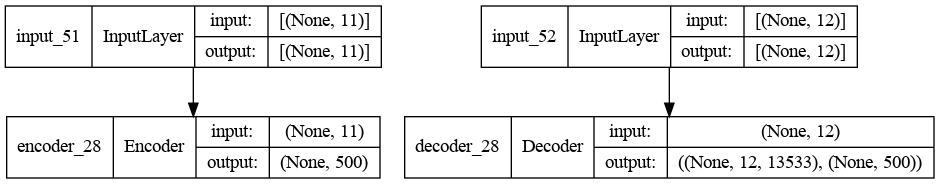

In [121]:
import tensorflow as tf
import tensorflow_addons as tfa

UNITS = 500
BATCH_SIZE = 32

class Encoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.embed = tf.keras.layers.Embedding(input_dim = VOCAB_SIZE, 
                                               output_dim = EMBEDDING_DIM, 
                                               input_length=MAX_SEQ_LEN_ENCODER,
                                               trainable=True, #we set trainable=True to train word embeddings during training
                                               mask_zero=True, #to ignore padding tokens
                                               embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix))
        self.gru1 = tf.keras.layers.GRU(UNITS, return_sequences=True, return_state=True, dropout=0.2, recurrent_initializer='glorot_uniform')
        self.gru2 = tf.keras.layers.GRU(UNITS, return_sequences=True, return_state=True, dropout=0.2, recurrent_initializer='glorot_uniform')

        
        
    def call(self, x):
        embed = self.embed(x)
        out, h = self.gru1(embed)
        out, h = self.gru2(out, initial_state=h)
        return h


class Decoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.embed = tf.keras.layers.Embedding(input_dim = VOCAB_SIZE, 
                                               output_dim = EMBEDDING_DIM, 
                                               input_length=MAX_SEQ_LEN_DECODER,
                                               trainable=True, #we set trainable=True to train word embeddings during training
                                               mask_zero=True, #to ignore padding tokens
                                               embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix))
        """
        Tried implementing AdditiveAttention but no success
        self.attention = tf.keras.layers.AdditiveAttention()
        self.Wc = tf.keras.layers.Dense(UNITS, activation="tanh", use_bias=False)
        """
        self.gru1 = tf.keras.layers.GRU(UNITS, return_sequences=True, return_state=True, dropout=0.2, recurrent_initializer='glorot_uniform')
        self.gru2 = tf.keras.layers.GRU(UNITS, return_sequences=True, return_state=True, dropout=0.2, recurrent_initializer='glorot_uniform')
        #Prediction layer with softmax function to get probabilities for each token in the vocabulary
        self.fc = tf.keras.layers.Dense(VOCAB_SIZE, activation='softmax')
        
    def call(self, x, init_state):
        embed = self.embed(x)
        out, h = self.gru1(embed, initial_state = init_state)
        out, h = self.gru2(out, initial_state = h)
        """
        context_vector, attention_weights = self.attention([out, init_state], return_attention_scores=True)

        # Step 4. Eqn. (3): Join the context_vector and rnn_output
        #     [ct; ht] shape: (batch t, value_units + query_units)
        context_and_rnn_output = tf.keras.layers.Concatenate(axis=-1)([context_vector, out])

        # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
        attention_vector = self.Wc(context_and_rnn_output)
        
        out = self.fc(attention_vector)
        """
        out = self.fc(out)
        return out, h

#Initialize the Encoder and Decoder
encoder_model = Encoder()
decoder_model = Decoder()

#Define Input shapes
encoder_inputs = tf.keras.layers.Input(shape=(MAX_SEQ_LEN_ENCODER,))
decoder_inputs = tf.keras.layers.Input(shape=(MAX_SEQ_LEN_DECODER,))

#Assign variables to models
enc_state = encoder_model(encoder_inputs)
decoder_outputs, _ = decoder_model(decoder_inputs, enc_state)

#Define the Model
seq2seq = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

#Plot model
from keras.utils.vis_utils import plot_model
plot_model(seq2seq, show_shapes=True, show_layer_names=True)

In [123]:
BATCH_SIZE = 32
EPOCHS = 10
loss = tf.losses.SparseCategoricalCrossentropy()
seq2seq.compile(optimizer="nadam", loss=loss, metrics=['accuracy'])
seq2seq.fit([encoder_input, decoder_input], decoder_output,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS)

Epoch 1/10
442/442 [==============================] - 25s 32ms/step - loss: 3.4804 - accuracy: 0.3415
Epoch 2/10
442/442 [==============================] - 15s 33ms/step - loss: 2.1648 - accuracy: 0.5271
Epoch 3/10
442/442 [==============================] - 14s 32ms/step - loss: 1.4338 - accuracy: 0.6283
Epoch 4/10
442/442 [==============================] - 14s 32ms/step - loss: 0.8759 - accuracy: 0.7596
Epoch 5/10
442/442 [==============================] - 14s 32ms/step - loss: 0.4978 - accuracy: 0.8679
Epoch 6/10
442/442 [==============================] - 15s 33ms/step - loss: 0.2983 - accuracy: 0.9241
Epoch 7/10
442/442 [==============================] - 14s 32ms/step - loss: 0.1943 - accuracy: 0.9530
Epoch 8/10
442/442 [==============================] - 14s 32ms/step - loss: 0.1401 - accuracy: 0.9670
Epoch 9/10
442/442 [==============================] - 14s 33ms/step - loss: 0.1136 - accuracy: 0.9728
Epoch 10/10
442/442 [==============================] - 15s 33ms/step - loss: 0.094

In [124]:
seq2seq.save_weights("seq2seq.h5")

##Different Sampling techniques with evaluation (BLEU score)

We will experiment different sampling methods:

1. Greedy search
2. Top-k sampling
3. Temperature sampling
4. Beam search

###Greedy search

In [125]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def encode_sequence(seq):
    encoded_seq = []
    for j in seq.split(" "):
      if j != "":
        encoded_seq.append(word2idx[j])
    encoded_seq = [encoded_seq]
    padded_seq = pad_sequences(encoded_seq, maxlen=MAX_SEQ_LEN_ENCODER, padding="post", truncating="pre")
    return padded_seq

def greedy_search(predictions):
    return np.argmax(predictions)

def greedy_sampling(input_seq):
    state = encoder_model(input_seq)
    target_seq = np.array([[word2idx['<SOS>']]])
    decoded_sentence = ''
    while True:
        output_tokens, state = decoder_model(target_seq, state)
        preds = output_tokens[0, -1, :]
        sampled_token_index = greedy_search(preds)
        sampled_char = idx2word[sampled_token_index]
        decoded_sentence += sampled_char
        decoded_sentence += " "
        if (sampled_char == '<EOS>' or
           len(decoded_sentence.split()) > 7):
            decoded_sentence = re.sub("<EOS>", "",decoded_sentence)
            break
        target_seq = np.array([[sampled_token_index]])
    return decoded_sentence

input_seq = "Nel mezzo del cammin di nostra vita"
generated_text = []
for i in range (0, 5):
  padded_seq = encode_sequence(input_seq)
  decoded_sentence = greedy_sampling(padded_seq)
  print(decoded_sentence)
  generated_text.append(decoded_sentence)
  input_seq = decoded_sentence

onde maligno spesso discerne ne torse altre braccia 
verso settentrion Se Se vedere  
maraviglia grazioso  
benedetto cortese  
benedetto cortese  


In [126]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

def bleu(data, generated, weights=(0.25,0.25,0.25,0.25)):
  cc = SmoothingFunction()
  references = [seq.text.split() for seq in data]
  hypothesis = [seq.split() for seq in generated]
  scores = []
  for i in range(len(hypothesis)):
    bleu_score = sentence_bleu(references, generated[i], weights=weights, smoothing_function=cc.method4)
    scores.append(bleu_score)
  return sum(scores)/len(scores)
  
print(f"BLEU score for greedy sampling: {bleu(sequences, generated_text)}\n")

BLEU score for greedy sampling: 0.01764365974494128



###Temperature sampling

In [127]:
def temperature(predictions, temp):
    conditional_probability = np.asarray(predictions).astype("float64")
    conditional_probability = np.log(conditional_probability) / temp
    exp_preds = np.exp(conditional_probability)
    conditional_probability = exp_preds / np.sum(exp_preds)
    probs = np.random.multinomial(1, conditional_probability, 1)
    return np.argmax(probs)

def temperature_sampling(input_seq, temp):
    state = encoder_model(input_seq)
    target_seq = np.array([[word2idx['<SOS>']]])
    decoded_sentence = ''
    while True:
        output_tokens, state = decoder_model(target_seq, state)
        preds = output_tokens[0, -1, :]
        sampled_token_index = temperature(preds, temp=temp)
        sampled_char = idx2word[sampled_token_index]
        decoded_sentence += sampled_char
        decoded_sentence += " "
        if (sampled_char == '<EOS>' or
           len(decoded_sentence.split()) > 7):
            decoded_sentence = re.sub("<EOS>", "",decoded_sentence)
            break
        target_seq = np.array([[sampled_token_index]])
    return decoded_sentence


temperatures = [0.3, 0.7, 1, 1.5]
for t in temperatures:
  print(f"Sampling with temperature {t}:")
  generated_text = []
  input_seq = "Nel mezzo del cammin di nostra vita"
  for i in range (0, 5):
    padded_seq = encode_sequence(input_seq)
    decoded_sentence = temperature_sampling(padded_seq, t)
    print(decoded_sentence)
    generated_text.append(decoded_sentence)
    input_seq = decoded_sentence
  print(f"BLEU score for temperature {t}: {bleu(sequences, generated_text)}\n")

Sampling with temperature 0.3:
onde disfavilla Tale campagna quando  
sanza distinzione se ' frutti Ben puote puote 
etterno riguardando se ' ntendi se ' ntendi 
etterno intelletto e quello suono de le rede 
etterno intelletto e altro puote ama che sia 
BLEU score for temperature 0.3: 0.012275325973785233

Sampling with temperature 0.7:
verso picciola distese dove levai le spalle e 
sanza conoscenza ne rube avvinte e cresciuto ne 
etterno resplende ne convegna m' aiuti e disse 
picciol vederai ricchi e lavi vi puose  
maraviglia palese spirto come ciel de le rede 
BLEU score for temperature 0.7: 0.01205621230501042

Sampling with temperature 1:
costoro sospeccioso falseggiando quanta augelli mio  
mirabil pietosamente alternando  
orgoglio cortese Per modo insurgo  
etterno levato  
principio priva usanza  
BLEU score for temperature 1: 0.01648941689780723

Sampling with temperature 1.5:
penitenza spense lusinghe vanta Felice  
giron diritto chiavi  
splendori region Romena come grifo 

### Top-k sampling

In [129]:
def softmax(z):
   return np.exp(z)/sum(np.exp(z))

def top_k(predictions, k):
    top_k_probabilities, top_k_indices= tf.math.top_k(predictions, k=k, sorted=True)
    top_k_indices = np.asarray(top_k_indices).astype("int32")
    top_k_redistributed_probability=softmax(np.log(top_k_probabilities))
    top_k_redistributed_probability = np.asarray(top_k_redistributed_probability).astype("float32")
    sampled_token = np.random.choice(top_k_indices, p=top_k_redistributed_probability)
    return sampled_token

def top_k_sampling(input_seq, k):
    state = encoder_model(input_seq)
    target_seq = np.array([[word2idx['<SOS>']]])
    decoded_sentence = ''
    while True:
        output_tokens, state = decoder_model(target_seq, state)
        preds = output_tokens[0, -1, :]
        sampled_token_index = top_k(preds, k=k)
        sampled_char = idx2word[sampled_token_index]
        decoded_sentence += sampled_char
        decoded_sentence += " "
        if (sampled_char == '<EOS>' or
           len(decoded_sentence.split()) > 7):
            decoded_sentence = re.sub("<EOS>", "",decoded_sentence)
            break
        target_seq = np.array([[sampled_token_index]])
    return decoded_sentence


input_seq = "Nel mezzo del cammin di nostra vita"
generated_text = []
for i in range (0, 5):
  padded_seq = encode_sequence(input_seq)
  decoded_sentence = top_k_sampling(padded_seq, 10)
  print(decoded_sentence)
  generated_text.append(decoded_sentence)
  input_seq = decoded_sentence
print(f"BLEU score for top-k sampling: {bleu(sequences, generated_text)}\n")

onde maligno come creatura vedi o fren metti 
onde parevi Però lava  
appresso paladino  
infinito fisso pio pio pio ti rispondo nè 
libero peccato Se Se manifesto  
BLEU score for top-k sampling: 0.01829532971148996



###Beam search

In [130]:
def get_candidates(target_seq, state, k):
    output_tokens, state = decoder_model(target_seq, state)
    preds = output_tokens[0, -1, :]
    top_k_probabilities, top_k_indices= tf.math.top_k(preds, k=k, sorted=True)
    top_k_indices = np.asarray(top_k_indices).astype("int32")
    top_k_probabilities = np.asarray(top_k_probabilities).astype("float32")
    return top_k_indices, top_k_probabilities
    

def beam_search_inference(input_seq, k=3, max_words=5):
    state = encoder_model(input_seq)
    scores = [[("<SOS>", 1.0)]]
    target_seq = np.array([[word2idx['<SOS>']]])
    for c in range (0, max_words):
      for i in range (len(scores[c])):
        k_scores = []
        for seq, score in scores[c]:
          target_seq = np.array([[word2idx[seq.split()[-1]]]])
          top_k_indices, top_k_probabilities = get_candidates(target_seq, state, k)
          for j in range (0, k):
            inner_sentence = seq + " " + idx2word[top_k_indices[j]]
            inner_score = score * np.log(top_k_probabilities[j])
            inner_tup = (inner_sentence, inner_score)
            k_scores.append(inner_tup)
      scores.append(k_scores)
    final_candidates = np.array([s for c,s in scores[-1]])
    max_prob_idx = np.argmax(final_candidates)
    final_seq = scores[-1][max_prob_idx][0]
    final_seq = re.sub("<SOS> ", "",final_seq)
    return final_seq


input_seq = "Nel mezzo del cammin di nostra vita"
generated_text = []
for i in range (0, 5):
  padded_seq = encode_sequence(input_seq)
  decoded_sentence = beam_search_inference(padded_seq, k=2, max_words=6)
  print(decoded_sentence)
  generated_text.append(decoded_sentence)
  input_seq = decoded_sentence
print(f"BLEU score for beam search: {bleu(sequences, generated_text)}\n")

onde maligno maraviglia forte maraviglia forte
maraviglia perfetto intelletto etterno etterno etterno
etterno peccato maraviglia allegrezza benedetto benedetto
maraviglia allegrezza aspettar allegrezza aspettar allegrezza
etterno peccato maraviglia allegrezza benedetto benedetto
BLEU score for beam search: 0.010308649125204152



# Extra - Term frequency?

In [ ]:
"""from collections import Counter

def frequent_words(df):
  corpus = [text for text in df.Text]
  corpus = reduce(lambda x,y: x+y, corpus)
  tokens = nlp(corpus)
  df_list = [word.text for word in tokens]
  word_counts = Counter(df_list)
  del word_counts["\n"]
  most_common = word_counts.most_common(50)
  words = list(zip(*most_common))[0]
  counts = list(zip(*most_common))[1]
  plt.figure(figsize=(20, 10))
  plt.bar(words, counts)
  plt.show()
  return word_counts

word_counts = frequent_words(df)"""

'from collections import Counter\n\ndef frequent_words(df):\n  corpus = [text for text in df.Text]\n  corpus = reduce(lambda x,y: x+y, corpus)\n  tokens = nlp(corpus)\n  df_list = [word.text for word in tokens]\n  word_counts = Counter(df_list)\n  del word_counts["\n"]\n  most_common = word_counts.most_common(50)\n  words = list(zip(*most_common))[0]\n  counts = list(zip(*most_common))[1]\n  plt.figure(figsize=(20, 10))\n  plt.bar(words, counts)\n  plt.show()\n  return word_counts\n\nword_counts = frequent_words(df)'

In [ ]:
"""def compute_tf(word_counts):
  n_tokens = np.sum(list(word_counts.values()))
  for k in word_counts:
    word_counts[k] = 1 + np.log10(word_counts[k]) 
  return word_counts


term_freq = compute_tf(word_counts)"""

'def compute_tf(word_counts):\n  n_tokens = np.sum(list(word_counts.values()))\n  for k in word_counts:\n    word_counts[k] = 1 + np.log10(word_counts[k]) \n  return word_counts\n\n\nterm_freq = compute_tf(word_counts)'

In [ ]:
def get_tf_matrix(input):
    tf_matrix = np.zeros(shape=(input.shape[0], input.shape[1]))
    for i, sequence in enumerate(input):
      for j, word in enumerate(sequence):
        tf_matrix[i, j] = term_freq[idx2word[word]]
    return tf_matrix
      
tf_matrix = get_tf_matrix(decoder_input)